Centrifuge Test DAQ Analysis
=============


This notebook can:

1. Reads the DAQ data and plots it
2. One can provide offset, scale and select the range for x and y axis

---
Created by: [Sumeet Kumar Sinha](http://www.sumeetksinha.com),
PhD Student, University of California Davis

## Reading DAQ File

In [4]:
import os
import sys
# nb_dir = 'C:\\Users\\sumee\\Google Drive\\git\\Python-Scripts'
# if nb_dir not in sys.path:
#     sys.path.append(nb_dir)
    
import struct
import re
import binascii
import numpy as np
from ipywidgets import *
import ipywidgets
import array
# import h5py
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
# plt.style.use('classic')
%matplotlib nbagg

#####################################
# Folder Dialog Box
#####################################
import traitlets
from IPython.display import display
from ipywidgets import widgets
from tkinter import Tk, filedialog
import os; 
#####################################

#####################################
# For Dataframe : convert string to StringIO
#####################################
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import pandas

# #######################################
# # User defined modules
# import BrowseFolderWidget
# #######################################

class DAQdata(object):
    """DAQdata reads the binary data file produced by Center of Geotechnical Engineering UC Davis. 
    """

    def __init__(self, FileName, Reading_Rate = 100000):
        
        ExcelConfig                   = '';                       
        Sampling_Rate                 = 1;
        Number_of_Channels            = 0;
        Number_of_Hardware_Channels   = 0;
        Number_of_Xdcr_Serial_Numbers = 0;
        Channel_List                  = [];
        Hardware_Channel_List         = [];
        Xdcr_Serial_Numbers_List      = [];
        Number_of_Samples             = 0;
        Data_Length                   = 0;
        Channel_Dictionary            = {};

        with open(FileName,"rb") as f:

            ##################################################
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[readme]"):
                newLine = (f.readline()).strip();
            ## Read the readme content of the file here
#             print("Readme_Done!")
            ##################################################

            ##################################################
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[Hardware channel name list]"):
                newLine = (f.readline()).strip();
            ## Read the hardware channel name list
            newLine = ((f.readline()).strip()).decode();
            Hardware_Channel_List = newLine.split(',');
            Number_of_Hardware_Channels = len(Hardware_Channel_List);
            Hardware_Channel_List = Hardware_Channel_List[0:Number_of_Channels];
            # print Hardware_Channel_List
#             print("Hardware channel name list Done!")
            ##################################################

            ##################################################
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[channel name list]"):
                newLine = ((f.readline()).strip());
            ## Read the channel name list
            newLine = ((f.readline()).strip()).decode();
            Channel_List = newLine.split(',');
            Number_of_Channels = len(Channel_List);
            Channel_List = Channel_List[0:Number_of_Channels];
            Channel_List.append('Time');
            # print Channel_List
            ##################################################

            ##################################################
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[Xdcr Serial Numbers]"):
                newLine = ((f.readline()).strip());
            ## Read the Xdcr Serial Numbers
            newLine = ((f.readline()).strip()).decode();
            Xdcr_Serial_Numbers_List = newLine.split(',');
            Number_of_Xdcr_Serial_Numbers = len(Xdcr_Serial_Numbers_List);
            Xdcr_Serial_Numbers_List = Xdcr_Serial_Numbers_List[0:Number_of_Channels];
            # print Xdcr_Serial_Numbers_List
            ##################################################

            ##################################################
            Sampling_Rate = 1;
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[excelconfig]"):
                # print newLine.decode()
                newLine = (f.readline()).strip();
                if(newLine.decode()=="[sampling rate]"):
                    data = f.read(4);
                    Sampling_Rate = struct.unpack('>f',data[0: 4])[0];

            Num_of_excel_config = Number_of_Channels;
            if(Sampling_Rate==1):
                Num_of_excel_config = Num_of_excel_config-1;
            for i in range(0,Num_of_excel_config):
                newLine = (f.readline()).strip();
                ExcelConfig = ExcelConfig +newLine.decode() +'\n';
            ## Read the excelconfig of the file here
            ##################################################

            ##################################################
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[data]"):
                newLine = (f.readline()).strip();

            ###################################################
            #### Reading number of samples in the binary file
            ###################################################

            old_file_position = f.tell()
            f.seek(0, os.SEEK_END)
            size = f.tell()
            f.seek(old_file_position, os.SEEK_SET)

            Estimated_Total_Data_Length = size/4 ; # estimated data length 
            Estimated_Number_Of_Samples = Estimated_Total_Data_Length/Number_of_Channels; # estimated number of samples

            ##################################################
            #### Actual length of data 
            ##################################################

            Num_Iterations = int (Estimated_Total_Data_Length/Reading_Rate)+1;
            Data_Length    = 0;
            for i in range(0,Num_Iterations):
                data = np.fromfile(f, dtype='>f',count=Reading_Rate);
                Data_Length = Data_Length + len(data);

            data = [];
            Number_of_Samples = Data_Length/Number_of_Channels;

            ##################################################
            #### Creating Channel Dictionary
            ##################################################

            index_list = 0;
            for x in Channel_List:
                Channel_Dictionary[x]=index_list;
                index_list = index_list+1;
            Channel_Dictionary['Time'] = -1;

#             print(Channel_Dictionary);
           
        self.FileName = FileName;
        self.Sampling_Rate                 = Sampling_Rate                ;
        self.Number_of_Channels            = Number_of_Channels           ;
        self.Number_of_Hardware_Channels   = Number_of_Hardware_Channels  ;
        self.Number_of_Xdcr_Serial_Numbers = Number_of_Xdcr_Serial_Numbers;
        self.Channel_List                  = Channel_List                 ;
        self.Hardware_Channel_List         = Hardware_Channel_List        ;
        self.Xdcr_Serial_Numbers_List      = Xdcr_Serial_Numbers_List     ;
        self.Number_of_Samples             = Number_of_Samples            ;
        self.Data_Length                   = Data_Length                  ;
        self.Channel_Dictionary            = Channel_Dictionary           ;
        self.ExcelConfig                   = ExcelConfig                  ;

    def Plot(self, Sensor_Name1, Sensor_Name2, Figure_Number = 0,  ScaleX= 1, OffsetX = 0, ScaleY= 1, OffsetY = 0, Color = 'k', Reading_Rate = 5000000 ):
        
         with open(self.FileName,"rb") as f:

            ##################################################
            Sampling_Rate = 1;
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[excelconfig]"):
                # print newLine.decode()
                newLine = (f.readline()).strip();
                if(newLine.decode()=="[sampling rate]"):
                    data = f.read(4);
                    Sampling_Rate = struct.unpack('>f',data[0: 4])[0];
                    newLine = (f.readline()).strip();
            ##################################################
            
            ##################################################
            ## Navigating the pointer to the location where 
            ## information is stored
            newLine = ((f.readline()).strip());
            while (newLine.decode()!="[data]"):
                newLine = (f.readline()).strip();
            ##################################################

            ##################################################
            if(Figure_Number<=0):
                plt.figure();
            else:
                plt.figure(Figure_Number);
            ##################################################

            ##################################################
            ## Correct reading length based on number of channels 
            ##################################################
            Reading_Rate = int(Reading_Rate/self.Number_of_Channels)*self.Number_of_Channels;
            #################################################

            Sensor1_Index = self.Channel_Dictionary[Sensor_Name1];
            Sensor2_Index = self.Channel_Dictionary[Sensor_Name2];

#             print(Sensor1_Index);
#             print(Sensor2_Index);

            #################################################
            ### Reading Data
            #################################################
            Num_Iterations = int (self.Data_Length/Reading_Rate)+1;
            time = 0;Time = []
            for i in range(0,Num_Iterations):

                Sensor1_Data = []; Sensor2_Data = [];

                data = np.fromfile(f, dtype='>f',count=Reading_Rate);

                ######################################################################################
                correct_datalength = int(len(data)/self.Number_of_Channels)*self.Number_of_Channels;
                data = data[0:correct_datalength];
                Reading_Sampling_Rate = int(correct_datalength/self.Number_of_Channels);
                data = data.reshape(Reading_Sampling_Rate,self.Number_of_Channels);
                ######################################################################################

                if(Sensor1_Index==-1):
                    Time = np.linspace(time, time+(Reading_Sampling_Rate-1)*1.0/self.Sampling_Rate, num=Reading_Sampling_Rate);
                    if(len(Time)==0):
                        time =0;
                    else:
                        time = Time[-1];
                    Sensor1_Data = Time;
                else:
                    Sensor1_Data = (data[:,Sensor1_Index]).copy();

                if(Sensor2_Index==-1 and Sensor1_Index!=-1):
                    Time = np.linspace(time, time+(Reading_Sampling_Rate-1)*1.0/self.Sampling_Rate, num=Reading_Sampling_Rate);
                    if(len(Time)==0):
                        time =0;
                    else:
                        time = Time[-1];
                    Sensor2_Data = Time;
                elif(Sensor2_Index==-1 and Sensor1_Index==-1):
                    Sensor2_Data = Time;
                else:
                    Sensor2_Data = (data[:,Sensor2_Index]).copy();

                data = [];

                plt.plot(Sensor1_Data[:]*ScaleX+OffsetX, Sensor2_Data[:]*ScaleY+OffsetY,Color,label=Sensor_Name2); #plt.hold(True);

                Sensor1_Data = []; Sensor2_Data = [];

            plt.xlabel(Sensor_Name1)
            plt.grid(b=True, which='major', color='k', linestyle='-')
            plt.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
            plt.minorticks_on()
            plt.grid(True)
#             ax.tick_params(axis='x',which='minor',bottom='off')
#             plt.legend()
            plt.show()
    
    
    
    ###################################################################################################
    ### Extracts Data in the given time interval
    ###################################################################################################
    def Extract(self,User_Start_Time, User_End_Time,Reading_Rate = 500 ):
        
        UserStartIndex = int(User_Start_Time*(self.Sampling_Rate)); 
        UserEndIndex = int(User_End_Time*(self.Sampling_Rate))+1; 
        Sensor_Data = np.empty([0, self.Number_of_Channels])
        time = 0; Time=[];
        
        
#         print(UserStartIndex)
#         print(UserEndIndex)
        
        with open(self.FileName,"rb") as f:

            ##################################################
            Sampling_Rate = 1;
            newLine = (f.readline()).strip();
            while (newLine.decode()!="[excelconfig]"):
                # print newLine.decode()
                newLine = (f.readline()).strip();
                if(newLine.decode()=="[sampling rate]"):
                    data = f.read(4);
                    Sampling_Rate = struct.unpack('>f',data[0: 4])[0];
                    newLine = (f.readline()).strip();
            ##################################################
            
            ##################################################
            ## Navigating the pointer to the location where 
            ## information is stored
            newLine = ((f.readline()).strip());
            while (newLine.decode()!="[data]"):
                newLine = (f.readline()).strip();
            ##################################################

            ##################################################
            ## Correct reading length based on number of channels 
            ##################################################
            Reading_Rate = int(Reading_Rate/self.Number_of_Channels)*self.Number_of_Channels;
            #################################################

            #################################################
            ### Reading Data
            #################################################
            Num_Iterations = int (self.Data_Length/Reading_Rate)+1;
            DataStartIndex = 0;
            DataEndIndex   = 0;
            for i in range(0,Num_Iterations):

                data = np.fromfile(f, dtype='>f',count=Reading_Rate);

                ######################################################################################
                correct_datalength = int(len(data)/self.Number_of_Channels)*self.Number_of_Channels;
                data = data[0:correct_datalength];
                Reading_Sampling_Rate = int(correct_datalength/self.Number_of_Channels);
                data = data.reshape(Reading_Sampling_Rate,self.Number_of_Channels);
                ######################################################################################
                
                DataStartIndex = DataEndIndex;                
                DataEndIndex = DataStartIndex + Reading_Sampling_Rate;
#                 print ('DataEndIndex '+str(DataEndIndex));
#                 print ('DataStartIndex '+str(DataStartIndex));
#                 print ('UserStartIndex '+str(UserStartIndex));
#                 print ('UserEndIndex '+str(UserEndIndex));
#                 print ('Reading_Sampling_Rate '+str(Reading_Sampling_Rate));

                if(DataStartIndex >=UserStartIndex and DataEndIndex< UserEndIndex):
                    Sensor_Data = np.append(Sensor_Data,(data[:,:]).copy());
                    dTime = np.linspace(time, time+(Reading_Sampling_Rate-1)*1.0/self.Sampling_Rate, num=Reading_Sampling_Rate);
                    Time = np.append(Time,dTime);
                    time = Time[-1]+1/self.Sampling_Rate;
#                     print ('Condition 1');
                elif(DataStartIndex >=UserStartIndex and DataEndIndex>=UserEndIndex):
                    Sensor_Data = np.append(Sensor_Data,(data[: UserEndIndex-DataEndIndex,:]).copy());
#                     print(data[: UserEndIndex-DataEndIndex,:]);
                    dTime = np.linspace(time, time+(Reading_Sampling_Rate+(UserEndIndex-DataEndIndex)-1)*1.0/self.Sampling_Rate, num=Reading_Sampling_Rate+(UserEndIndex-DataEndIndex));
                    Time = np.append(Time,dTime);
                    time = Time[-1]+1/self.Sampling_Rate;
                    break ;
                elif(DataStartIndex < UserStartIndex and DataEndIndex< UserEndIndex):
#                     print ('Condition 3' + str (Reading_Sampling_Rate-(UserStartIndex-DataStartIndex)));
                    if(Reading_Sampling_Rate-(UserStartIndex-DataStartIndex)>=0):
                        Sensor_Data = np.append(Sensor_Data,(data[UserStartIndex-DataStartIndex:,:]).copy());
                        dTime = np.linspace(time, time+(Reading_Sampling_Rate-(UserStartIndex-DataStartIndex)-1)*1.0/self.Sampling_Rate, num=Reading_Sampling_Rate-(UserStartIndex-DataStartIndex));
                        Time = np.append(Time,dTime);
                        time = Time[-1]+1/self.Sampling_Rate;
                elif(DataStartIndex < UserStartIndex and DataEndIndex>=UserEndIndex):
#                     print ('Condition 4');
                    Sensor_Data = np.append(Sensor_Data,(data[UserStartIndex-DataStartIndex:UserEndIndex-DataEndIndex,:]).copy());
                    dTime = np.linspace(time, time+(Reading_Sampling_Rate-(UserStartIndex-DataStartIndex)+ (UserEndIndex-DataEndIndex)-1)*1.0/self.Sampling_Rate, num=Reading_Sampling_Rate+(UserEndIndex-DataEndIndex));
                    Time = np.append(Time,dTime);
                    time = Time[-1]+1/self.Sampling_Rate;
                    break ;
                   
        Sensor_Data = Sensor_Data.reshape(int(len(Sensor_Data)/self.Number_of_Channels),self.Number_of_Channels); 
             
#         print (Sensor_Data);
#         print (Sensor_Data.shape);
#         print (Time.shape);
        return Time, Sensor_Data 


# Choosing File

In [5]:
import os
import glob

style = {'description_width': 'initial'};

###################################################
### Browse Folder Widget
###################################################

BinaryDirectory = os.getcwd();
BrowseButton_Widget = widgets.Button(description='Choose Dir',style = style,layout = Layout(width='50%', height='30px'),)

BinaryDirectory_Widget = widgets.Label(value=BinaryDirectory)
os.chdir(BinaryDirectory);
File_List = glob.glob('*.bin')
    
def Select_Directory_Change(Change):
    global BinaryDirectory;
    global BinaryDirectory_Widget;
    global File_List;
    global BinFile_Widget;
    """Generate instance of tkinter.filedialog.
    Parameters
    """
    #print("I am here_1")
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    # Raise the root to the top of all windows.
    root.call('wm', 'attributes', '.', '-topmost', True)
    # List of selected fileswill be set to b.value
    # b.files = filedialog.askopenfilename(multiple=True)
    folder_selected = filedialog.askdirectory()
    BinaryDirectory_Widget.value = folder_selected;
    os.chdir(folder_selected);
    File_List = glob.glob('*.bin')
    #print (File_List)
    BinFile_Widget.options = File_List;
    BinFile_Widget.value = File_List[0];
    #print ("I am here_n")

BrowseButton_Widget.on_click(Select_Directory_Change)

################################################################


# os.chdir('C:\\Users\\sumee\\Box\\PEOPLE\\Sumeet_Sinha\\Centrifuge_Model_SKS#01\\Python_Gui_Application')
# DAQdata('05072018@114603@114948@999.0rpm.bin')
# DAQdata('05072018@114603@114948@999.0rpm.bin')

File_List = glob.glob('*.bin')
# print (File_List)
BinFileName   = File_List[0];
BinData       = DAQdata(BinFileName);
Channel_List = BinData.Channel_List;

###################################################
### Variables of the data plotted
###################################################
SensorX        = Channel_List[-1];
SensorX_Scale  = 1;
SensorX_Offset = 0;

SensorY1        = Channel_List[0];
SensorY1_Scale  = 1;
SensorY1_Offset = 0;

SensorY2      = Channel_List[0];
SensorY2_Plot = False;
SensorY2_Scale  = 1;
SensorY2_Offset = 0;

SensorY3     = Channel_List[0];
SensorY3_Plot = False;
SensorY3_Scale  = 1;
SensorY3_Offset = 0;

SensorY4     = Channel_List[0];
SensorY4_Plot = False;
SensorY4_Scale  = 1;
SensorY4_Offset = 0;

XAxis_Min = 0;
XAxis_Max = 1;

###################################################
### Binary File Widget 
###################################################

BinFile_Widget = widgets.Dropdown(
    options=File_List,
    value=File_List[0],
    description='File:',
    style = style,
)

# Writing the Sensor Information

In [6]:
# print(plt.style.available);
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.random(200).reshape(2, 100));
# df

# DAQ Data Plot Options

In [7]:

# layout=Layout(width='10%', height='30px');


##############################################
######## SensorX
###############################################
SensorX_Widget = widgets.Dropdown(
    options=Channel_List,
    value=Channel_List[-1],
    description=':',
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorX_CheckBox_Widget = widgets.Checkbox(
    value=True,
    description='SensorX',
    disabled=False,
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorX_Scale_Widget = widgets.FloatText(
    value=1.0,
    description='Scale:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

SensorX_Offset_Widget = widgets.FloatText(
    value=0,
    description='Offset:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

def SensorX_Widget_Change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global SensorX;
        SensorX = change['new'];
#         print (SensorX)
                       
def SensorX_CheckBox_Widget_Changed(b):
    global SensorX_CheckBox_Widget;
    SensorX_CheckBox_Widget.value=True;

def SensorX_Scale_Widget_Changed(b):
    global SensorX_Scale;
    global SensorX_Scale_Widget;
    SensorX_Scale = SensorX_Scale_Widget.value;
    
def SensorX_Offset_Widget_Changed(b):
    global SensorX_Offset;
    global SensorX_Offset_Widget;
    SensorX_Offset = SensorX_Offset_Widget.value;
    
    
SensorX_Widget.observe(SensorX_Widget_Change);
SensorX_CheckBox_Widget.observe(SensorX_CheckBox_Widget_Changed)
SensorX_Scale_Widget.observe(SensorX_Scale_Widget_Changed)
SensorX_Offset_Widget.observe(SensorX_Offset_Widget_Changed)

SensorX_Option_1 = HBox([SensorX_CheckBox_Widget,SensorX_Widget,SensorX_Scale_Widget,SensorX_Offset_Widget])

##############################################
######## SensorY1
###############################################
SensorY1_Widget = widgets.Dropdown(
    options=Channel_List,
    value=Channel_List[0],
    description=':',
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY1_CheckBox_Widget = widgets.Checkbox(
    value=True,
    description='SensorY1 (black)',
    disabled=False,
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY1_Scale_Widget = widgets.FloatText(
    value=1.0,
    description='Scale:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

SensorY1_Offset_Widget = widgets.FloatText(
    value=0,
    description='Offset:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

def SensorY1_Widget_Change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global SensorY1;
        SensorY1 = change['new']; 
        
def SensorY1_CheckBox_Widget_Changed(b):
    global SensorY1_CheckBox_Widget;
    SensorY1_CheckBox_Widget.value=True;

def SensorY1_Scale_Widget_Changed(b):
    global SensorY1_Scale;
    global SensorY1_Scale_Widget;
    SensorY1_Scale = SensorY1_Scale_Widget.value;
    
def SensorY1_Offset_Widget_Changed(b):
    global SensorY1_Offset;
    global SensorY1_Offset_Widget;
    SensorY1_Offset = SensorY1_Offset_Widget.value;

SensorY1_Widget.observe(SensorY1_Widget_Change);
SensorY1_CheckBox_Widget.observe(SensorY1_CheckBox_Widget_Changed)
SensorY1_Scale_Widget.observe(SensorY1_Scale_Widget_Changed)
SensorY1_Offset_Widget.observe(SensorY1_Offset_Widget_Changed)

SensorY_Option_1 = HBox([SensorY1_CheckBox_Widget,SensorY1_Widget,SensorY1_Scale_Widget,SensorY1_Offset_Widget])

##############################################
######## SensorY2
###############################################
SensorY2_Widget = widgets.Dropdown(
    options=Channel_List,
    value=Channel_List[0],
    description=':',
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY2_CheckBox_Widget = widgets.Checkbox(
    value=False,
    description='SensorY2 (red)',
    disabled=False,
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY2_Scale_Widget = widgets.FloatText(
    value=1.0,
    description='Scale:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

SensorY2_Offset_Widget = widgets.FloatText(
    value=0,
    description='Offset:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)


def SensorY2_Widget_Change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global SensorY2;
        SensorY2 = change['new']; 
        
        
def SensorY2_CheckBox_Widget_Changed(b):
    global SensorY2_Widget;
    global SensorY2_CheckBox_Widget;
    global SensorY2_Plot;
        
    if(SensorY2_CheckBox_Widget.value==True):
        SensorY2_Widget.layout.visibility= 'visible'
        SensorY2_Scale_Widget.layout.visibility= 'visible'
        SensorY2_Offset_Widget.layout.visibility= 'visible'
        SensorY2_Plot = True;
    else:
        SensorY2_Widget.layout.visibility= 'hidden'
        SensorY2_Scale_Widget.layout.visibility= 'hidden'
        SensorY2_Offset_Widget.layout.visibility= 'hidden'
        SensorY2_Plot = False;

def SensorY2_Scale_Widget_Changed(b):
    global SensorY2_Scale;
    global SensorY2_Scale_Widget;
    SensorY2_Scale = SensorY2_Scale_Widget.value;
    
def SensorY2_Offset_Widget_Changed(b):
    global SensorY2_Offset;
    global SensorY2_Offset_Widget;
    SensorY2_Offset = SensorY2_Offset_Widget.value;

SensorY2_Widget.observe(SensorY2_Widget_Change);
SensorY2_CheckBox_Widget.observe(SensorY2_CheckBox_Widget_Changed);
SensorY2_Scale_Widget.observe(SensorY2_Scale_Widget_Changed);
SensorY2_Offset_Widget.observe(SensorY2_Offset_Widget_Changed);

SensorY2_Widget.layout.visibility= 'hidden'
SensorY2_Scale_Widget.layout.visibility= 'hidden'
SensorY2_Offset_Widget.layout.visibility= 'hidden'

SensorY_Option_2 = HBox([SensorY2_CheckBox_Widget,SensorY2_Widget,SensorY2_Scale_Widget,SensorY2_Offset_Widget])

##############################################
######## SensorY3
###############################################
SensorY3_Widget = widgets.Dropdown(
    options=Channel_List,
    value=Channel_List[0],
    description=':',
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY3_CheckBox_Widget = widgets.Checkbox(
    value=False,
    description='SensorY3 (blue)',
    disabled=False,
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY3_Scale_Widget = widgets.FloatText(
    value=1.0,
    description='Scale:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

SensorY3_Offset_Widget = widgets.FloatText(
    value=0,
    description='Offset:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

def SensorY3_Widget_Change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global SensorY3;
        SensorY3 = change['new']; 
        
        
def SensorY3_CheckBox_Widget_Changed(b):
    global SensorY3_Widget;
    global SensorY3_Plot;
    global SensorY3_CheckBox_Widget;
        
    if(SensorY3_CheckBox_Widget.value==True):
        SensorY3_Widget.layout.visibility= 'visible'
        SensorY3_Scale_Widget.layout.visibility= 'visible'
        SensorY3_Offset_Widget.layout.visibility= 'visible'
        SensorY3_Plot = True;
    else:
        SensorY3_Widget.layout.visibility= 'hidden'
        SensorY3_Scale_Widget.layout.visibility= 'hidden'
        SensorY3_Offset_Widget.layout.visibility= 'hidden'
        SensorY3_Plot = False;

def SensorY3_Scale_Widget_Changed(b):
    global SensorY3_Scale;
    global SensorY3_Scale_Widget;
    SensorY3_Scale = SensorY3_Scale_Widget.value;
    
def SensorY3_Offset_Widget_Changed(b):
    global SensorY3_Offset;
    global SensorY3_Offset_Widget;
    SensorY3_Offset = SensorY3_Offset_Widget.value;


SensorY3_Widget.observe(SensorY3_Widget_Change);
SensorY3_CheckBox_Widget.observe(SensorY3_CheckBox_Widget_Changed)
SensorY3_Scale_Widget.observe(SensorY3_Scale_Widget_Changed)
SensorY3_Offset_Widget.observe(SensorY3_Offset_Widget_Changed)

SensorY3_Widget.layout.visibility= 'hidden'
SensorY3_Scale_Widget.layout.visibility= 'hidden'
SensorY3_Offset_Widget.layout.visibility= 'hidden'


SensorY_Option_3 = HBox([SensorY3_CheckBox_Widget,SensorY3_Widget,SensorY3_Scale_Widget,SensorY3_Offset_Widget])

##############################################
######## SensorY4
###############################################
SensorY4_Widget = widgets.Dropdown(
    options=Channel_List,
    value=Channel_List[0],
    description=':',
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY4_CheckBox_Widget = widgets.Checkbox(
    value=False,
    description='SensorY4 (green)',
    disabled=False,
    style = style,
    layout = Layout(width='20%', height='30px'),
)

SensorY4_Scale_Widget = widgets.FloatText(
    value=1.0,
    description='Scale:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

SensorY4_Offset_Widget = widgets.FloatText(
    value=0,
    description='Offset:',
    disabled=False,
    style = style,
    layout = Layout(width='30%', height='30px'),
)

def SensorY4_Widget_Change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global SensorY4;
        SensorY4 = change['new']; 
        
def SensorY4_CheckBox_Widget_Changed(b):
    global SensorY4_Widget;
    global SensorY4_CheckBox_Widget;
    global SensorY4_Plot;
        
    if(SensorY4_CheckBox_Widget.value==True):
        SensorY4_Widget.layout.visibility= 'visible'
        SensorY4_Scale_Widget.layout.visibility= 'visible'
        SensorY4_Offset_Widget.layout.visibility= 'visible'
        SensorY4_Plot = True;
    else:
        SensorY4_Widget.layout.visibility= 'hidden'
        SensorY4_Scale_Widget.layout.visibility= 'hidden'
        SensorY4_Offset_Widget.layout.visibility= 'hidden'
        SensorY4_Plot = False;
    
def SensorY4_Scale_Widget_Changed(b):
    global SensorY4_Scale;
    global SensorY4_Scale_Widget;
    SensorY4_Scale = SensorY4_Scale_Widget.value;
    
def SensorY4_Offset_Widget_Changed(b):
    global SensorY4_Offset;
    global SensorY4_Offset_Widget;
    SensorY4_Offset = SensorY4_Offset_Widget.value;

SensorY4_Widget.observe(SensorY4_Widget_Change);
SensorY4_CheckBox_Widget.observe(SensorY4_CheckBox_Widget_Changed)
SensorY4_Scale_Widget.observe(SensorY4_Scale_Widget_Changed)
SensorY4_Offset_Widget.observe(SensorY4_Offset_Widget_Changed)

SensorY4_Widget.layout.visibility= 'hidden'
SensorY4_Scale_Widget.layout.visibility= 'hidden'
SensorY4_Offset_Widget.layout.visibility= 'hidden'

SensorY_Option_4 = HBox([SensorY4_CheckBox_Widget,SensorY4_Widget,SensorY4_Scale_Widget,SensorY4_Offset_Widget])
###############################################
###############################################


## Clipping the plots

In [8]:
XAxis_Min_Widget = widgets.FloatText(
                    value=XAxis_Min,
                    description='X_Axis_Min:',
                    disabled=False,
                    style = style,
                    layout = Layout(width='80%', height='30px'),
                   )
XAxis_Max_Widget = widgets.FloatText(
                    value=XAxis_Max,
                    description='X_Axis_Max:',
                    disabled=False,
                    style = style,
                    layout = Layout(width='80%', height='30px'),
                   )

def XAxis_Min_Widget_Changed(b):
    global XAxis_Min_Widget;
    global XAxis_Min;
    global XAxis_Max;
    if(XAxis_Min_Widget.value<XAxis_Min):
        XAxis_Min_Widget.value=XAxis_Min;
    if(XAxis_Min_Widget.value>XAxis_Max):
        XAxis_Min_Widget.value=XAxis_Max;        

def XAxis_Max_Widget_Changed(b):
    global XAxis_Max_Widget;
    global XAxis_Max;
    global XAxis_Min;
    if(XAxis_Max_Widget.value<XAxis_Min):
        XAxis_Max_Widget.value=XAxis_Min;
    if(XAxis_Max_Widget.value>XAxis_Max):
        XAxis_Max_Widget.value=XAxis_Max;  
    
XAxis_Min_Widget.observe(XAxis_Min_Widget_Changed)
XAxis_Max_Widget.observe(XAxis_Max_Widget_Changed)


In [9]:
global Sensor_Information_Widget;
global Horizontal_Box_1;

####################################################################################
#####################################################################################
TESTDATA = StringIO(BinData.ExcelConfig);
Sensor_Info = pandas.read_csv(TESTDATA)
Sensor_Information_Widget = ipywidgets.HTML(Sensor_Info.style.set_table_attributes('class="table"').render());

def BinFile_Widget_Change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global BinFileName;
        global BinData;
        global Channel_List;
        global Sensor_Information_Widget;
        global Horizontal_Box_1;
        BinFileName = change['new'];
        BinData = DAQdata(BinFileName);
        Channel_List = BinData.Channel_List;
        
        global SensorX_Widget;
        global SensorY1_Widget;
        global SensorY2_Widget;
        global SensorY3_Widget;
        global SensorY4_Widget;
        SensorX_Widget.options = Channel_List; SensorX_Widget.value = Channel_List[-1]
        SensorY1_Widget.options = Channel_List;SensorY1_Widget.value = Channel_List[0]
        SensorY2_Widget.options = Channel_List;SensorY2_Widget.value = Channel_List[0]
        SensorY3_Widget.options = Channel_List;SensorY3_Widget.value = Channel_List[0]
        SensorY4_Widget.options = Channel_List;SensorY4_Widget.value = Channel_List[0]
        
        
        ###################################################
        ### Reset Variables of the data plotted
        ###################################################
        global SensorX; global SensorX_Scale; global SensorX_Offset;
        SensorX        = Channel_List[-1];
        SensorX_Scale  = 1;
        SensorX_Offset = 0;

        global SensorY1; global SensorY1_Scale; global SensorY1_Offset;
        SensorY1        = Channel_List[0];
        SensorY1_Scale  = 1;
        SensorY1_Offset = 0;
    
        global SensorY2; global SensorY2_Scale; global SensorY2_Offset;
        SensorY2      = Channel_List[0];
        SensorY2_Plot = False;
        SensorY2_Scale  = 1;
        SensorY2_Offset = 0;
        
        global SensorY3; global SensorY3_Scale; global SensorY3_Offset;
        SensorY3     = Channel_List[0];
        SensorY3_Plot = False;
        SensorY3_Scale  = 1;
        SensorY3_Offset = 0;
        
        global SensorY4; global SensorY4_Scale; global SensorY4_Offset;
        SensorY4     = Channel_List[0];
        SensorY4_Plot = False;
        SensorY4_Scale  = 1;
        SensorY4_Offset = 0;
        
        TESTDATA = StringIO(BinData.ExcelConfig);
        Sensor_Info = pandas.read_csv(TESTDATA)
        Sensor_Information_Widget = ipywidgets.HTML(Sensor_Info.style.set_table_attributes('class="table"').render());
        Horizontal_Box_1 = HBox(children=[Sensor_Information_Widget]);
#         Horizontal_Box_1.children([Sensor_Information_Widget]);

        #display(Horizontal_Box_1)

BinFile_Widget.observe(BinFile_Widget_Change)

######################################################################################
######################################################################################

SensorPlot_Widget = widgets.Button(description="Plot!")

def SensorPlot_Clicked(b):
    global XAxis_Min, XAxis_Max; 
    global XAxis_Min_Widget,XAxis_Max_Widget;
    plt.gcf().clear()
#     print (SensorX);
#     print (SensorY1);
    Figure_Number = 1;
    BinData.Plot(SensorX,SensorY1, Figure_Number, SensorX_Scale, SensorX_Offset, SensorY1_Scale, SensorY1_Offset, '-k')
    if(SensorY2_Plot==True):
        BinData.Plot(SensorX,SensorY2, Figure_Number, SensorX_Scale, SensorX_Offset, SensorY2_Scale, SensorY2_Offset, '-r')
    if(SensorY3_Plot==True):
        BinData.Plot(SensorX,SensorY3, Figure_Number, SensorX_Scale, SensorX_Offset, SensorY3_Scale, SensorY3_Offset, '-b')
    if(SensorY4_Plot==True):
        BinData.Plot(SensorX,SensorY4, Figure_Number, SensorX_Scale, SensorX_Offset, SensorY4_Scale, SensorY4_Offset, '-g')
    
    XAxis_Min,XAxis_Max = plt.xlim()  # return the current xlim
    
    XAxis_Min_Widget.value = XAxis_Min;
    XAxis_Max_Widget.value = XAxis_Max;
    
SensorPlot_Widget.on_click(SensorPlot_Clicked);

######################################################################################
######################################################################################
ClipPlot_Widget = widgets.Button(description="Clip it")

def ClipPlot_Clicked(b):
    global XAxis_Min_Widget,XAxis_Max_Widget;
    plt.xlim((XAxis_Min_Widget.value, XAxis_Max_Widget.value))

ClipPlot_Widget.on_click(ClipPlot_Clicked);

# Final GUI Assembly

VBox(children=(Tab(children=(HBox(children=(VBox(children=(Button(description='Choose Dir', layout=Layout(height='30px', width='50%'), style=ButtonStyle()), Dropdown(description='File:', index=19, options=('08042020@093550.bin', '08042020@140700.bin', '08222020@140729.bin', '08222020@140729@144129@999.0rpm.bin', '08252020@181008.bin', '08252020@181008@181901@999.0rpm.bin', '08252020@183030.bin', '08252020@223251.bin', '08262020@070121.bin', '08262020@170140.bin', '08272020@060949.bin', '08272020@091814.bin', '08272020@091814@104029@64.5rpm.bin', '08272020@091814@105210@64.4rpm.bin', '08272020@091814@111447@64.5rpm.bin', '08272020@091814@113338@64.4rpm.bin', '08272020@091814@115551@64.2rpm.bin', '08272020@091814@115643@64.2rpm.bin', '08282020@072827.bin', '08282020@091729.bin', '08282020@091729@100121@64.5rpm.bin', '08282020@091729@102507@64.5rpm.bin', '08282020@091729@104225@64.5rpm.bin', '08282020@091729@110705@64.4rpm.bin', '08282020@091729@112326@64.4rpm.bin', '08282020@091729@114313@64.2rpm.bin', '08282020@091729@120938@64.5rpm.bin', '08282020@091729@140425@64.4rpm.bin', '08282020@091729@141727@64.5rpm.bin', '08282020@091729@142116@64.6rpm.bin', '08282020@091729@144401@64.7rpm.bin'), style=DescriptionStyle(description_width='initial'), value='08282020@091729.bin'), FloatText(value=0.0, description='X_Axis_Min:', layout=Layout(height='30px', width='80%'), style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='X_Axis_Max:', layout=Layout(height='30px', width='80%'), style=DescriptionStyle(description_width='initial')), Button(description='Clip it', style=ButtonStyle()))), VBox(children=(HBox(children=(Checkbox(value=True, description='SensorX', layout=Layout(height='30px', width='20%'), style=DescriptionStyle(description_width='initial')), Dropdown(description=':', index=83, layout=Layout(height='30px', width='20%'), options=('TIME', 'RPM', 'ICP1-0', 'ICP1-1', 'ICP1-2', 'ICP1-3', 'ICP1-4', 'ICP1-5', 'ICP2-0', 'ICP2-1', 'ICP2-2', 'ICP2-3', 'ICP2-4', 'ICP2-5', 'ICP2-6', 'ICP2-7', 'Bridge3-0', 'Bridge3-1', 'Bridge3-2', 'Bridge3-3', 'Bridge3-4', 'Bridge3-5', 'Bridge3-6', 'Bridge3-7', 'Bridge4-0', 'Bridge4-1', 'Bridge4-2', 'Bridge4-3', 'Bridge4-4', 'Bridge4-5', 'ICP3-0', 'ICP6-0', 'ICP6-1', 'ICP6-2', 'ICP6-3', 'ICP6-4', 'ICP6-5', 'Bridge9-0', 'Bridge9-1', 'Bridge9-2', 'Bridge10-0', 'Bridge10-1', 'Bridge10-2', 'Bridge10-3', 'Bridge10-4', 'Bridge10-5', 'Bridge10-6', 'Bridge10-7', 'Bridge11-0', 'Bridge11-1', 'Bridge11-2', 'Bridge11-3', 'Bridge12-0', 'Bridge12-1', 'Bridge12-2', 'Bridge12-3', 'Bridge12-4', 'Bridge12-5', 'Bridge12-6', 'Bridge12-7', 'HOC 2-0', 'HOC 2-1', 'HOC 2-2', 'HOC 2-3', 'HOC 2-4', 'HOC 2-5', 'HOC 2-6', 'HOC 2-7', 'HOC 3-0', 'HOC 3-1', 'HOC 3-2', 'HOC 3-3', 'HOC 3-4', 'HOC 3-5', 'HOC 3-6', 'HOC 3-7', 'HOC 5-0', 'HOC 6-0', 'HOC 6-3', 'LC1', 'LC2', 'HOC 7-0', 'HOC 7-1', 'Time'), style=DescriptionStyle(description_width='initial'), value='Time'), FloatText(value=1.0, description='Scale:', layout=Layout(height='30px', width='30%'), style=DescriptionStyle(description_width='initial')), FloatText(value=0.0, description='Offset:', layout=Layout(height='30px', width='30%'), style=DescriptionStyle(description_width='initial')))), HBox(children=(Checkbox(value=True, description='SensorY1 (black)', layout=Layout(height='30px', width='20%'), style=DescriptionStyle(description_width='initial')), Dropdown(description=':', layout=Layout(height='30px', width='20%'), options=('TIME', 'RPM', 'ICP1-0', 'ICP1-1', 'ICP1-2', 'ICP1-3', 'ICP1-4', 'ICP1-5', 'ICP2-0', 'ICP2-1', 'ICP2-2', 'ICP2-3', 'ICP2-4', 'ICP2-5', 'ICP2-6', 'ICP2-7', 'Bridge3-0', 'Bridge3-1', 'Bridge3-2', 'Bridge3-3', 'Bridge3-4', 'Bridge3-5', 'Bridge3-6', 'Bridge3-7', 'Bridge4-0', 'Bridge4-1', 'Bridge4-2', 'Bridge4-3', 'Bridge4-4', 'Bridge4-5', 'ICP3-0', 'ICP6-0', 'ICP6-1', 'ICP6-2', 'ICP6-3', 'ICP6-4', 'ICP6-5', 'Bridge9-0', 'Bridge9-1', 'Bridge9-2', 'Bridge10-0', 'Bridge10-1', 'Bridge10-2', 'Bridge10-3', 'Bridge10-4', 'Bridge10-5', 'Br

<IPython.core.display.Javascript object>


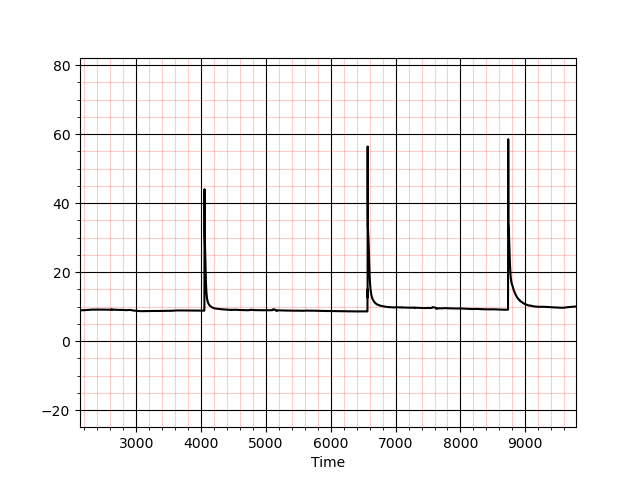

In [13]:
Tab1_Vertical_1 = VBox(children=[BrowseButton_Widget,BinFile_Widget,XAxis_Min_Widget,XAxis_Max_Widget,ClipPlot_Widget])
# BrowseButton_Widget
Tab1_Vertical_2 = VBox(children=[SensorX_Option_1,SensorY_Option_1, SensorY_Option_2, SensorY_Option_3, SensorY_Option_4])
Tab1_Horizontal = HBox(children=[Tab1_Vertical_1,Tab1_Vertical_2])
Horizontal_Box_1 = HBox(children=[Sensor_Information_Widget])

tab = widgets.Tab(children=[Tab1_Horizontal,Horizontal_Box_1])
tab.set_title(0, 'Sensor Plot')
tab.set_title(1, 'Sensor Information')
Final = VBox(children=[tab, SensorPlot_Widget])

# display(Horizontal_Box_1)
# print (SensorX);

# XAxis_Min_Widget
# XAxis_Max_Widget

display(Final)
# display(YAxis_SideBar)

# VBox([SensorX_Option_1,SensorY_Option_1, SensorY_Option_2, SensorY_Option_3, SensorY_Option_4 ])
# # right_box = VBox([items[2], items[3]])
# # HBox([left_box, right_box])

In [11]:
# DAQ1 = DAQdata("05162018@162334@163306@999.0rpm_10Hz_300_Strikes_Hammer_Height_08mm.bin");
# # # # DAQ1 = DAQdata("05072018@114603@114948@999.0rpm.bin")
# print (DAQ1.Number_of_Channels);
# Channel_Dictionary = DAQ1.Channel_Dictionary;
# print (Channel_Dictionary)
# # # plt.clf();
# # DAQ1.Plot('Time','HOC 7-1', Figure_Number=1)

# Time, Clipped_Data = DAQ1.Extract( 0, 0.001);
# # plt.plot(Time, Clipped_Data[:,Channel_Dictionary['HOC 7-1']])
# plt.plot(Clipped_Data[:,Channel_Dictionary['HOC 7-0']], Clipped_Data[:,Channel_Dictionary['HOC 7-1']])




